In [283]:
#Importando bibliotecas
import os 
import sqlalchemy
from sqlalchemy.sql.elements import Label, collate
import numpy as np
import pandas as pd
from pandas.core.arrays import categorical
from pandas.io.formats.format import TextAdjustment
from pandas.io.pickle import read_pickle
from scipy import sparse
import sweetviz as sv
import matplotlib.pyplot as plt
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, RandomizedSearchCV, GridSearchCV
from sweetviz import feature_config
import lightgbm as lgb
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn import tree, ensemble, svm, neighbors, linear_model, naive_bayes
from sklearn.metrics import roc_curve , classification_report, roc_auc_score
pd.set_option('display.max_columns',100)

## Carregando o Banco de Dados
O Banco de dados deve acessar a tabela **tb_abt_no_sells**

In [284]:
# Carregando os paths do banco de dados
dir_local = os.path.dirname(os.path.abspath('__file__'))
dir_project = os.path.dirname(dir_local)
dir_db = os.path.join(dir_project,'Data/olist.db')
# Efetuando a conexão com o SQLAlchemy e carregando o Dataset
con = sqlalchemy.create_engine('sqlite:///'+ dir_db)
load_abt_churn = "SELECT * from tb_abt_no_sells"
dataset = pd.read_sql(load_abt_churn , con)

## Separando uma parte do dataset para Out of Time (OOT)
Nesse caso serão separadas as **2 últimas safras** para OOT as restantes serão utilizadas para o desenvolvimento

In [302]:
safras = dataset['data_lim_safra'].unique()
safras_oot = safras[-1:]

dataset['flag_venda'] = dataset['flag_venda'].astype(int)
dataset['estado'] = dataset['estado'].astype('category')
df_oot = dataset[ dataset['data_lim_safra'] >= safras_oot[0]].copy()
df = dataset[ dataset['data_lim_safra'] < safras_oot[0]].copy()
df.shape

(15234, 25)

## Manipulando e separando as Features

In [303]:
# Separando as colunas de features e target e separando os dados entre treino e teste
target = 'flag_venda'
df_columns = df.columns.to_list()
to_remove = ['flag_venda', 'data_lim_safra', 'seller_id']
features = [i for i in df_columns if i not in to_remove]

## Um pouco sobre os dados do Dataset

* Flag Venda = possui dados desbalanceado (69%/31%)  
* Data Limite Safra = Demonstra um crescimento na quantidade de vendas já que são apenas computadas as vendas que foram realmente efetivadas,  
* Estado = Demonstra uma predominancia dos vendedores residentes no estado de SP seguido do PR
* Idade Dias = Pode-se observar que a maioria dos usuários possui menos de 5 meses na plataforma
***Qtde de Vendas  = 21.1% deste dataset com vendedores com apenas uma venda, ***
* Variedade de Produtos = Mais de 50% do do dataset possui 3 produtos como variedade vendidas



In [329]:
# Carregando o relatório através do SweetViz
# Alguns valores nulos foram encontrados e que serão substituidos pela mediana
report = sv.analyze(df)
report.show_html()


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [305]:
sellers_fraude = df.query('ticket_medio>1500 and avaliacao_safra < 2')['seller_id'].unique().tolist()

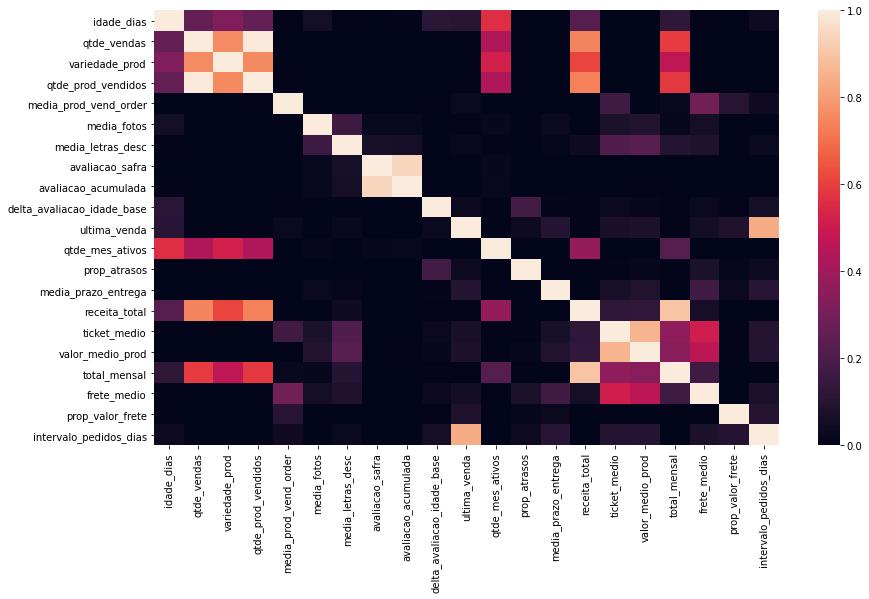

In [306]:
plt.figure(figsize = (14, 8))
correlation = df[features].corr(method = 'pearson')
ax = sns.heatmap(correlation, vmin=0, vmax=1)

In [307]:
df = df.query('seller_id not in @sellers_fraude')

# Variaveis com correlacoes altas
corr_alta = ['qtde_vendas','avaliacao_acumulada']
features = [i for i in features if i not in corr_alta]

# Separando as features entre categóricas e numéricas

cat_features = df[features].dtypes[df[features].dtypes == 'category'].index.tolist()
num_features = df[features].dtypes[df[features].dtypes !='category'].index.tolist()


## Separando a variável resposta e dividindo entre treino e teste
Será utilizado 25% dos dados para teste e 75% para treino

In [309]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                                    stratify= df[target], random_state= 200)


## Definição da Pipeline *para as variáveis*

Para as variáveis numéricas será aplicado o Simple Imputer substituindo os valores pela mediana e posteriormente aplicando o MinMax Scaler para o pre-processamento.
Para as variáveis categóricas será aplicado o One Hot Encoder


In [310]:
num_enc = Pipeline([('imputer' , SimpleImputer(missing_values= np.nan , strategy='median')),
                    ('scaler', MinMaxScaler())])
preparation = ColumnTransformer( transformers= [    ('numeric', num_enc, num_features),
                                                    ('categorical' , OneHotEncoder(handle_unknown = 'ignore'), cat_features)])

## Definição dos Algoritmos de Machine Learning
Selecionando alguns algoritmos para verificar os resultados de cada um deles

In [311]:
algoritmos = [ 
                # Tree
                tree.DecisionTreeClassifier(min_samples_leaf = 0.01 ),
                tree.ExtraTreeClassifier(min_samples_leaf = 0.01),
                # SVM
                svm.LinearSVC(),
                # Neighbors
                neighbors.KNeighborsClassifier(n_neighbors = 7),
                # Naive Bayes
                naive_bayes.BernoulliNB(),
                naive_bayes.GaussianNB(),
                # GLM
                linear_model.LogisticRegression(),
                linear_model.RidgeClassifier(),
                linear_model.SGDClassifier(),
                linear_model.Perceptron(),
                # Ensemble Methods
                ensemble.AdaBoostClassifier(),
                ensemble.GradientBoostingClassifier(),
                ensemble.ExtraTreesClassifier(min_samples_leaf = 0.01),
                ensemble.RandomForestClassifier(min_samples_leaf = 0.01),
                lgb.LGBMClassifier(is_unbalance=True)
                ]

## Validação Cruzada com os Algoritmos a serem usados nas Pipelines


In [312]:
#Criando um Dataframe com os resultados assim pode-se comparar os resultados

MLA_cols = ["MLA Name", "MLA Parameters", "MLA Train ROC_AUC Mean", "MLA Test ROC_AUC Mean", "MLA Test ROC_AUC DV Pad", "MLA Time"]
MLA_Compare = pd.DataFrame(columns=MLA_cols)
row_index = 0 # set index

# A métrica utilizada para escolha do melhor algoritmo será a ROC AUC

cv_split = ShuffleSplit(random_state=123)
for algoritmo in algoritmos:
    pipe_loop = Pipeline([  ('prep' , preparation),
                            ('alg' , algoritmo)])
    MLA_name = pipe_loop['alg'].__class__.__name__ # Name of the Algorithm
    print(f"Processando o algoritmo {MLA_name}") 
    MLA_Compare.loc[row_index,"MLA Name"]  = MLA_name
    MLA_Compare.loc[row_index, "MLA Parameters"] = str(pipe_loop['alg'].get_params())
    cv_results = cross_validate(pipe_loop, X= df[features], y= df[target], cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='roc_auc')
    #Resultados da validação cruzada
    MLA_Compare.loc[row_index, "MLA Time"] = cv_results['fit_time'].mean()
    MLA_Compare.loc[row_index, "MLA Train ROC_AUC Mean"] = cv_results['train_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC Mean"] = cv_results['test_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC DV Pad"] = cv_results['test_score'].std()*3
    row_index +=1

MLA_Compare.sort_values(by="MLA Test ROC_AUC Mean", ascending=False, inplace=True , ignore_index=True)

Processando o algoritmo DecisionTreeClassifier
Processando o algoritmo ExtraTreeClassifier
Processando o algoritmo LinearSVC
Processando o algoritmo KNeighborsClassifier
Processando o algoritmo BernoulliNB
Processando o algoritmo GaussianNB
Processando o algoritmo LogisticRegression
Processando o algoritmo RidgeClassifier
Processando o algoritmo SGDClassifier
Processando o algoritmo Perceptron
Processando o algoritmo AdaBoostClassifier
Processando o algoritmo GradientBoostingClassifier
Processando o algoritmo ExtraTreesClassifier
Processando o algoritmo RandomForestClassifier
Processando o algoritmo LGBMClassifier


## Resultados da Validação Cruzada

Os resultados plotados no gráfico abaixo mostrou que os 2 algoritmos (Random Forest Classifier e Extra Trees Classifier) resultaram em um valor da métrica ROC AUC  
interessante, porém os parametros default como ***max_depth = None, min_samples_split = 2, min_samples_leaf=1*** tendem ao algoritmo realizar overfit nos dados de treino.  
Apesar dos resultados terem sido próximos estarei optando pelo algoritmo de *Extra Trees Classifier* pois possui um tempo menor de processamento\
facilitando a próxima etapa de otimização de Hyperparametros e também permitir entender as Decisões.
Será aplicado uma "poda" nas arvores para tornar o algoritmo mais generalista, evitando assim um overfit nesta etapa.

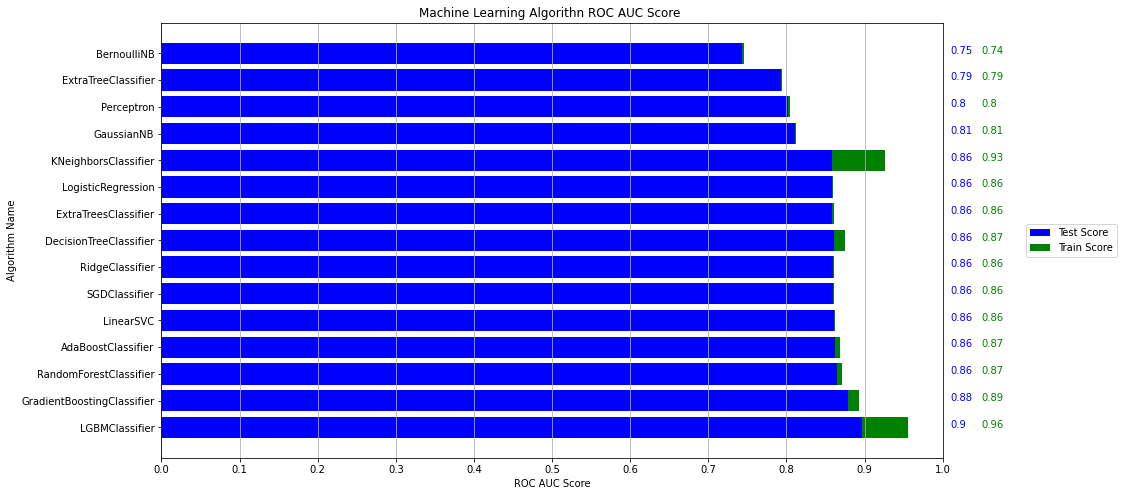

In [313]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Test ROC_AUC Mean'], color = 'b' , label = 'Test Score')
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Train ROC_AUC Mean']-MLA_Compare['MLA Test ROC_AUC Mean'], color = 'g', label = "Train Score", left=MLA_Compare['MLA Test ROC_AUC Mean'] )
for index, data in enumerate(MLA_Compare['MLA Test ROC_AUC Mean']):
    plt.text(x=1.01 , y = index, s=MLA_Compare['MLA Test ROC_AUC Mean'][index].round(2) ,color = "b")
    plt.text(x=1.05 , y = index, s=MLA_Compare['MLA Train ROC_AUC Mean'][index].round(2), color = "g")
plt.xlim(0,1)
ax.grid(axis="x")
plt.ylabel("Algorithm Name")
plt.xlabel("ROC AUC Score")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('Machine Learning Algorithn ROC AUC Score ')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()

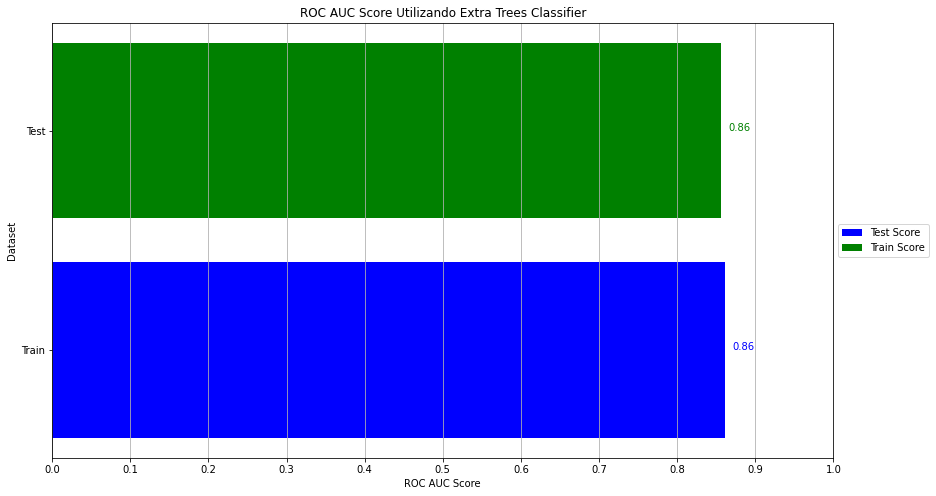

In [174]:
reduce_overfit_params = {  "min_samples_split" : 0.01, 
                            "min_samples_leaf" : 0.01,
                            "max_depth" : 25}
pipeline_Ex_tree = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.ExtraTreesClassifier(**reduce_overfit_params))])
cv_results_stp1 = cross_validate(pipeline_Ex_tree, X= X_train, y= y_train, cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='roc_auc')

fig1, ax1 = plt.subplots(figsize = (14, 8))
ax1.barh(y="Train", width=cv_results_stp1['train_score'].mean(), color = 'b' , label = 'Test Score')
ax1.barh(y="Test", width=cv_results_stp1['test_score'].mean(), color = 'g', label = "Train Score" )
plt.text(x=cv_results_stp1['train_score'].mean()+0.01 , y = "Train", s=cv_results_stp1['train_score'].mean().round(2) ,color = "b")
plt.text(x=cv_results_stp1['test_score'].mean()+0.01 , y = "Test", s=cv_results_stp1['test_score'].mean().round(2), color = "g")
plt.xlim(0,1)
ax1.grid(axis="x")
plt.ylabel("Dataset")
plt.xlabel("ROC AUC Score")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('ROC AUC Score Utilizando Extra Trees Classifier')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [334]:
# functions para auxiliar a visualização dos resultados.

def report(y_true, X, pipe, titulo= None):
    y_pred = pipe.predict(X)
    print(titulo)
    print(classification_report(y_true, y_pred, target_names = ['Não Vendeu', 'Vendeu']))

def plot_roc_curve(fpr, tpr, titulo = None):
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title("Curva ROC")
    plt.legend(title = "Base de dados", )
    plt.plot(fpr, tpr, label = titulo)
    plt.show()

## Verificando as métricas

### Extra Trees Classifier

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.78      0.38      0.51      1191
      Vendeu       0.77      0.95      0.85      2618

    accuracy                           0.77      3809
   macro avg       0.77      0.67      0.68      3809
weighted avg       0.77      0.77      0.75      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.83      0.45      0.59       604
      Vendeu       0.77      0.95      0.85      1177

    accuracy                           0.78      1781
   macro avg       0.80      0.70      0.72      1781
weighted avg       0.79      0.78      0.76      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.86
AUC SCORE OOT Dataset: 0.87


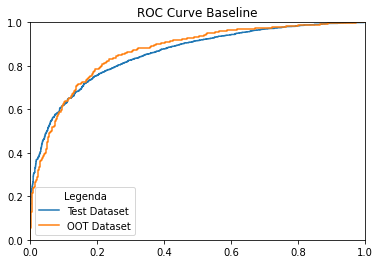

In [176]:
# Resultados com o Dataset de Testes e OOT

pipeline_Ex_tree.fit(X_train[features], y_train)
# Dataset de Teste
report(y_test,X_test, pipeline_Ex_tree, "Test Dataset")
df_test_pred = pipeline_Ex_tree.predict(X_test)
df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)

# OOT Dataset
report(df_oot[target],df_oot[features], pipeline_Ex_tree, "OOT Dataset")
df_oot_pred = pipeline_Ex_tree.predict(df_oot[features])
pred_oot_proba =  pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba ).round(2)}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

### Logistic Regression

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.63      0.71      0.67      1191
      Vendeu       0.86      0.81      0.83      2618

    accuracy                           0.78      3809
   macro avg       0.75      0.76      0.75      3809
weighted avg       0.79      0.78      0.78      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.71      0.75      0.73       604
      Vendeu       0.87      0.84      0.85      1177

    accuracy                           0.81      1781
   macro avg       0.79      0.79      0.79      1781
weighted avg       0.81      0.81      0.81      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.85
AUC SCORE OOT Dataset: 0.87


(0.0, 1.0)

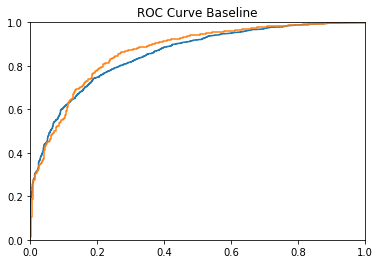

In [177]:
pipeline_log_regr = Pipeline([   ('prep' , preparation),
                                ('alg' , linear_model.LogisticRegression(max_iter=500, class_weight="balanced" ))])

pipeline_log_regr.fit(X_train[features], y_train)
# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
report(y_test,X_test, pipeline_log_regr, "Test Dataset")
df_test_pred = pipeline_log_regr.predict(X_test)
df_test_pred_proba = pipeline_log_regr.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)

# OOT Dataset
report(df_oot[target],df_oot[features], pipeline_log_regr, "OOT Dataset")
df_oot_pred = pipeline_log_regr.predict(df_oot[features])
pred_oot_proba =  pipeline_log_regr.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba ).round(2)}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)

### Gradient Boosting

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.71      0.62      0.66      1191
      Vendeu       0.84      0.88      0.86      2618

    accuracy                           0.80      3809
   macro avg       0.77      0.75      0.76      3809
weighted avg       0.80      0.80      0.80      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.76      0.65      0.70       604
      Vendeu       0.83      0.90      0.86      1177

    accuracy                           0.81      1781
   macro avg       0.80      0.77      0.78      1781
weighted avg       0.81      0.81      0.81      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.87
AUC SCORE OOT Dataset: 0.88


(0.0, 1.0)

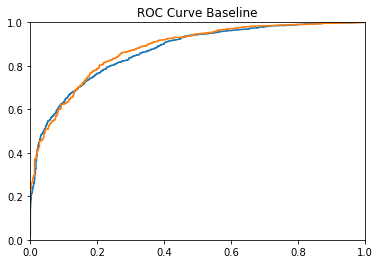

In [178]:
pipeline_grad_boosting = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.GradientBoostingClassifier())])

pipeline_grad_boosting.fit(X_train[features], y_train)
# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
report(y_test,X_test, pipeline_grad_boosting, "Test Dataset")
df_test_pred = pipeline_grad_boosting.predict(X_test)
df_test_pred_proba = pipeline_grad_boosting.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)

# OOT Dataset
report(df_oot[target],df_oot[features], pipeline_grad_boosting, "OOT Dataset")
df_oot_pred = pipeline_grad_boosting.predict(df_oot[features])
pred_oot_proba =  pipeline_grad_boosting.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba ).round(2)}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)

### Light GBM

In [315]:
preparation1 = ColumnTransformer( transformers=  [('numeric', num_enc, num_features)])

pipe_lgbm = Pipeline([  ('prep' , preparation1),
                        ('alg' , lgb.LGBMClassifier(is_unbalance =  True))])

pipe_lgbm.fit(X_train[features], y_train)
# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
report(y_test,X_test[features], pipe_lgbm, "Test Dataset")
y_test_proba = teste.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba, pos_label=1)

#OOT Dataset
report(df_oot[target],df_oot[features], pipe_lgbm, "OOT Dataset")
y_oot_proba =  pipe_lgbm.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, _ = roc_curve(df_oot[target], y_oot_proba, pos_label=1)

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,y_test_proba ).round(2)}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],y_oot_proba ).round(2)}')

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.66      0.81      0.73      1187
      Vendeu       0.90      0.81      0.85      2613

    accuracy                           0.81      3800
   macro avg       0.78      0.81      0.79      3800
weighted avg       0.83      0.81      0.81      3800

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.69      0.77      0.73       604
      Vendeu       0.88      0.82      0.85      1177

    accuracy                           0.80      1781
   macro avg       0.78      0.80      0.79      1781
weighted avg       0.81      0.80      0.81      1781

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.94
AUC SCORE OOT Dataset: 0.88


## Otimizacão dos Hyperparametros

### Extra Trees Classifier

In [155]:
# Otimizando os parametros do algoritmo com Randomized Search
'''
min_samples = np.linspace(start=0.02, stop=0.05 )

grid = {    "alg__n_estimators" : [100,200,500,1000],
            "alg__criterion" : ['gini','entropy'],
            "alg__max_depth" : [5,10,15,20,25],
            "alg__min_samples_split" : min_samples,
            "alg__min_samples_leaf" : min_samples}


otimizacao_tree = RandomizedSearchCV(    estimator=pipeline_Ex_tree, param_distributions=grid, 
                                    n_iter=600, n_jobs=-1, cv = cv_split, 
                                    scoring='roc_auc', verbose=1,
                                    random_state=123)
otimizacao_tree.fit(X_train[features], y_train)
resultados_tree = pd.DataFrame(otimizacao_tree.cv_results_)
resultados_tree.sort_values(by='rank_test_score', ascending= True, inplace=True)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-155-640a4ccc92a4>, line 18)

Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.81      0.32      0.46      1191
      Vendeu       0.76      0.97      0.85      2618

    accuracy                           0.76      3809
   macro avg       0.79      0.64      0.65      3809
weighted avg       0.77      0.76      0.73      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.84      0.38      0.52       604
      Vendeu       0.75      0.96      0.84      1177

    accuracy                           0.77      1781
   macro avg       0.80      0.67      0.68      1781
weighted avg       0.78      0.77      0.74      1781

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.85
Optimized AUC SCORE OOT Dataset: 0.86


(0.0, 1.0)

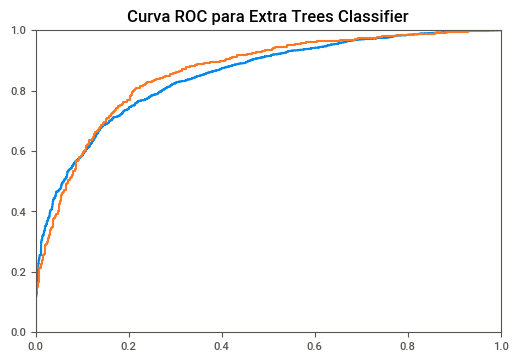

In [ ]:
'''pipeline_Ex_tree.set_params(**otimizacao_tree.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

report(y_test,X_test, pipeline_Ex_tree, "Test Dataset")
opt_df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_Ex_tree, "OOT Dataset")
opt_df_test_oot_proba = pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
roc_auc_score_test = roc_auc_score(y_test,opt_df_test_pred_proba ).round(2)
roc_auc_score_oot = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {roc_auc_score_test}')
print(f'Optimized AUC SCORE OOT Dataset: {roc_auc_score_oot}')

# Curva ROC com o Dataset de Teste e OOT
plt.title(label="Curva ROC para Extra Trees Classifier")
plt.xlim(0,1)
plt.ylim(0,1)

### Regressão Logistica
Como o resultado obtido com o Extra Trees foi bem semelhante aos outros, resolvi efetuar o Randomized Search tanto com a Logistic Regression quanto com a Extra Trees e verificar a perfomance de ambos.  
Nesta etapa selecionei alguns parametros para serem testados, em função do tempo longo de processamento estou utilizando o Randomized Search para localizar melhores parametros

In [ ]:
'''grid_logi_regre = {     "alg__penalty" : ['l1', 'l2', 'elasticnet'],
                        "alg__C" : np.logspace(-4, 50, 100)}

otimizacao_regression = RandomizedSearchCV(     estimator=pipeline_log_regr, param_distributions=grid_logi_regre, 
                                                n_iter=3000, n_jobs=-1, cv = cv_split, 
                                                scoring='roc_auc', verbose=1,
                                                random_state=123)
otimizacao_regression.fit(X_train[features], y_train)
resultados_reg = pd.DataFrame(otimizacao_regression.cv_results_)
resultados_reg.sort_values(by='rank_test_score', ascending= True, inplace=True)

/opt/anaconda3/envs/AutoMLPycarret/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 300 is smaller than n_iter=3000. Running 300 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 618 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2618 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.1min finished


Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.63      0.71      0.67      1191
      Vendeu       0.86      0.81      0.83      2618

    accuracy                           0.78      3809
   macro avg       0.75      0.76      0.75      3809
weighted avg       0.79      0.78      0.78      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.70      0.75      0.72       604
      Vendeu       0.87      0.83      0.85      1177

    accuracy                           0.81      1781
   macro avg       0.78      0.79      0.79      1781
weighted avg       0.81      0.81      0.81      1781

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.8531
Optimized AUC SCORE OOT Dataset: 0.865


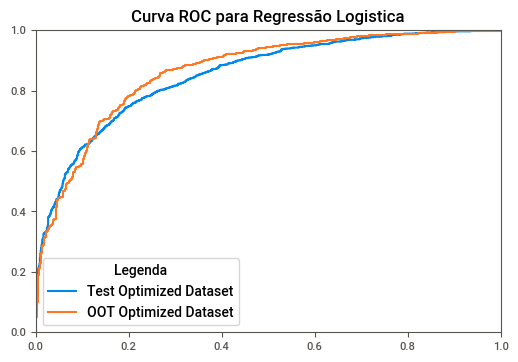

In [ ]:
'''pipeline_log_regr.set_params(**otimizacao_regression.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

report(y_test,X_test, pipeline_log_regr, "Test Dataset")
opt_df_test_pred_proba = pipeline_log_regr.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_log_regr, "OOT Dataset")
opt_df_test_oot_proba = pipeline_log_regr.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
auc_score_test_logit = roc_auc_score(y_test,opt_df_test_pred_proba ).round(2)
auc_score_oot_logit = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {auc_score_test_logit}')
print(f'Optimized AUC SCORE OOT Dataset: {auc_score_oot_logit}')

# Curva ROC com o Dataset de Teste e OOT
plt.title(label="Curva ROC para Regressão Logistica")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

### Gradient Boosting

In [156]:
grid_gboost =   {   "alg__loss" : ["deviance", "exponential"],
                    "alg__learning_rate" : [0.01, 0.05, 0.06, 0.1, 0.15, 0.20],
                    "alg__min_samples_split" : [0.003, 0.005, 0.007, 0.01 ],
                    "alg__min_samples_leaf" : [10,20,50,70],
                    "alg__max_depth" : [3,5,8],
                    "alg__subsample" : [0.8]    
                }

otimizacao_gboost = RandomizedSearchCV(     estimator=pipeline_grad_boosting, param_distributions=grid_gboost, 
                                                n_iter=200, n_jobs=-1, cv = cv_split, 
                                                scoring='roc_auc', verbose=1,
                                                random_state=123)
#otimizacao_gboost.fit(X_train[features], y_train)
#resultados_gboost = pd.DataFrame(otimizacao_gboost.cv_results_)
#resultados_gboost.sort_values(by='rank_test_score', ascending= True, inplace=True)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 25.9min finished


Test Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.78      0.70      0.74      1191
      Vendeu       0.87      0.91      0.89      2618

    accuracy                           0.85      3809
   macro avg       0.83      0.81      0.82      3809
weighted avg       0.84      0.85      0.84      3809

OOT Dataset
              precision    recall  f1-score   support

  Não Vendeu       0.78      0.70      0.74       604
      Vendeu       0.85      0.90      0.87      1177

    accuracy                           0.83      1781
   macro avg       0.81      0.80      0.81      1781
weighted avg       0.83      0.83      0.83      1781

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.9
Optimized AUC SCORE OOT Dataset: 0.88


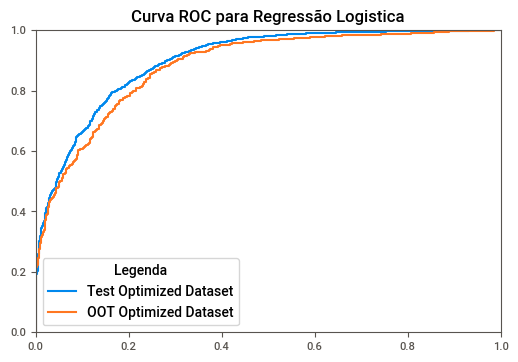

In [158]:
pipeline_grad_boosting.set_params(**otimizacao_gboost.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

report(y_test,X_test, pipeline_grad_boosting, "Test Dataset")
opt_df_test_pred_proba = pipeline_grad_boosting.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")

report(df_oot[target],df_oot[features], pipeline_grad_boosting, "OOT Dataset")
opt_df_test_oot_proba = pipeline_grad_boosting.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")

print("ROC AUC SCORE:")
auc_score_test_logit = roc_auc_score(y_test,opt_df_test_pred_proba ).round(2)
auc_score_oot_logit = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {auc_score_test_logit}')
print(f'Optimized AUC SCORE OOT Dataset: {auc_score_oot_logit}')

In [349]:

n_estimators  = range(50,1551,100)
params_boosting = { 'alg__n_estimators' : n_estimators}

pipeline_grad_boosting = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.GradientBoostingClassifier(learning_rate=0.25 ,min_samples_split=0.01, min_samples_leaf=50,max_depth=4, max_features='sqrt',subsample=0.8, random_state=10))])

gseatch1 = GridSearchCV(    estimator=pipeline_grad_boosting, param_grid= params_boosting, 
                            cv = cv_split, scoring="neg_log_loss", verbose=0 , n_jobs=-1)
gseatch1.fit(X_train[features], y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=123, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['idade_dias',
                                                                          'variedade_prod',
                                                                          'qtde_prod_vendidos',
                                                               

In [350]:
resultados_gboost = pd.DataFrame(gseatch1.cv_results_)

-0.408451 (0.010215) with: {'alg__n_estimators': 50}
-0.393852 (0.008809) with: {'alg__n_estimators': 150}
-0.385151 (0.009104) with: {'alg__n_estimators': 250}
-0.381211 (0.010601) with: {'alg__n_estimators': 350}
-0.373693 (0.011837) with: {'alg__n_estimators': 450}
-0.371564 (0.011949) with: {'alg__n_estimators': 550}
-0.370484 (0.013621) with: {'alg__n_estimators': 650}
-0.368705 (0.012568) with: {'alg__n_estimators': 750}
-0.369219 (0.013108) with: {'alg__n_estimators': 850}
-0.369058 (0.014109) with: {'alg__n_estimators': 950}
-0.370040 (0.011916) with: {'alg__n_estimators': 1050}
-0.371702 (0.011493) with: {'alg__n_estimators': 1150}
-0.373653 (0.012483) with: {'alg__n_estimators': 1250}
-0.375009 (0.012761) with: {'alg__n_estimators': 1350}
-0.377121 (0.013466) with: {'alg__n_estimators': 1450}
-0.379698 (0.012816) with: {'alg__n_estimators': 1550}


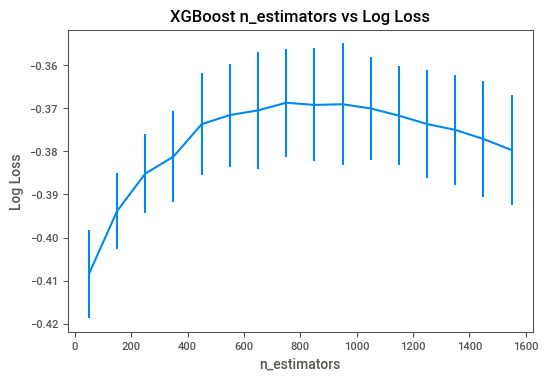

In [351]:
means = gseatch1.cv_results_['mean_test_score']
stds = gseatch1.cv_results_['std_test_score']
params = gseatch1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')

### Light Gradient Boosting

In [333]:
grid_lgbm = {   
                'alg__boosting_type' : ['gbdt'], # for better accuracy -> try dart
                'alg__colsample_bytree' : [0.75,0,65],
                'alg__learning_rate': [0.15, 0.2],
                'alg__max_bin':[255, 500], # large max_bin helps improve accuracy but might slow down training progress
                'alg__n_estimators': [300,500],
                'alg__num_leaves': [65,127], # large num_leaves helps improve accuracy but might lead to over-fitting
                'alg__objective' : ['binary'],
                'alg__reg_alpha' : [0.55, 0.65,0.75],
                'alg__reg_lambda' : [1, 1.4, 1.6],
                'alg__subsample' : [0.75],
            }

#optm_lgbm = RandomizedSearchCV(     estimator=pipe_lgbm, param_distributions=grid_lgbm, 
#                                    n_iter=300, n_jobs=-1, cv = cv_split, 
#                                    scoring='roc_auc', verbose=1,
#                                    random_state=123)

grid_sc_lgbm =GridSearchCV(estimator=pipe_lgbm, param_grid=grid_lgbm, n_jobs=-1, cv=cv_split, scoring='roc_auc',verbose=1)

grid_sc_lgbm.fit(X_train[features], y_train)

resultados_lgbm_refino = pd.DataFrame(grid_sc_lgbm.cv_results_)
resultados_lgbm_refino.sort_values(by='rank_test_score', ascending= True, inplace=True)


pipe_lgbm.set_params(**optm_lgbm.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

report(y_test,X_test, pipe_lgbm, "Test Dataset")
y_test_proba = pipe_lgbm.predict_proba(X_test)[:,1]

report(df_oot[target],df_oot[features], pipe_lgbm, "OOT Dataset")
y_oot_proba = pipe_lgbm.predict_proba(df_oot[features])[:,1]


print("ROC AUC SCORE:")
auc_score_test_lgbm = roc_auc_score(y_test,y_test_proba ).round(2)
auc_score_oot_lgbm = roc_auc_score(df_oot[target],y_oot_proba ).round(2)
print(f'Optimized AUC SCORE Test Dataset: {auc_score_test_lgbm}')
print(f'Optimized AUC SCORE OOT Dataset: {auc_score_oot_lgbm}')

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.3min finished


TypeError: 'DataframeReport' object is not callable

In [335]:
grid_sc_lgbm.best_params_

{'alg__boosting_type': 'gbdt',
 'alg__colsample_bytree': 0.75,
 'alg__learning_rate': 0.15,
 'alg__max_bin': 500,
 'alg__n_estimators': 500,
 'alg__num_leaves': 65,
 'alg__objective': 'binary',
 'alg__reg_alpha': 0.55,
 'alg__reg_lambda': 1.6,
 'alg__subsample': 0.75}

In [206]:
resultados_lgbm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alg__boosting_type,param_alg__colsample_bytree,param_alg__learning_rate,param_alg__max_bin,param_alg__n_estimators,param_alg__num_leaves,param_alg__objective,param_alg__reg_alpha,param_alg__reg_lambda,param_alg__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
761,1.966899,0.029516,0.080105,0.005614,gbdt,0.66,0.2,510,300,31,binary,0.8,0.8,0.75,"{'alg__boosting_type': 'gbdt', 'alg__colsample...",0.917824,0.918930,0.923134,0.918904,0.910492,0.917902,0.914587,0.917987,0.917650,0.919753,0.917716,0.003138,1
760,1.843182,0.043241,0.079837,0.006917,gbdt,0.66,0.2,510,300,31,binary,0.8,0.8,0.7,"{'alg__boosting_type': 'gbdt', 'alg__colsample...",0.917824,0.918930,0.923134,0.918904,0.910492,0.917902,0.914587,0.917987,0.917650,0.919753,0.917716,0.003138,1
698,1.365134,0.023580,0.070898,0.002275,gbdt,0.66,0.2,255,300,31,binary,0.8,1.4,0.7,"{'alg__boosting_type': 'gbdt', 'alg__colsample...",0.916632,0.920220,0.919381,0.915600,0.907507,0.919108,0.914605,0.921083,0.914773,0.921283,0.917019,0.003980,3
699,1.340683,0.025907,0.070704,0.003484,gbdt,0.66,0.2,255,300,31,binary,0.8,1.4,0.75,"{'alg__boosting_type': 'gbdt', 'alg__colsample...",0.916632,0.920220,0.919381,0.915600,0.907507,0.919108,0.914605,0.921083,0.914773,0.921283,0.917019,0.003980,3
379,1.656741,0.008995,0.072290,0.002577,gbdt,0.64,0.2,510,300,31,binary,0.8,1.4,0.75,"{'alg__boosting_type': 'gbdt', 'alg__colsample...",0.917063,0.928637,0.923655,0.916469,0.901803,0.915970,0.913008,0.915726,0.912076,0.917831,0.916224,0.006697,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,2.589170,0.013840,0.032869,0.001132,dart,0.64,0.01,510,200,15,binary,1.2,0.8,0.7,"{'alg__boosting_type': 'dart', 'alg__colsample...",0.869087,0.876135,0.868068,0.855173,0.851856,0.864234,0.859101,0.867284,0.865761,0.867594,0.864429,0.006812,1531
855,2.579243,0.024503,0.033708,0.002400,dart,0.64,0.01,510,200,15,binary,1.2,1.4,0.75,"{'alg__boosting_type': 'dart', 'alg__colsample...",0.869089,0.876284,0.868224,0.855175,0.852037,0.864057,0.859219,0.866978,0.865886,0.867336,0.864429,0.006784,1533
854,2.582078,0.023316,0.033058,0.002161,dart,0.64,0.01,510,200,15,binary,1.2,1.4,0.7,"{'alg__boosting_type': 'dart', 'alg__colsample...",0.869089,0.876284,0.868224,0.855175,0.852037,0.864057,0.859219,0.866978,0.865886,0.867336,0.864429,0.006784,1533
851,2.596139,0.013875,0.033166,0.002427,dart,0.64,0.01,510,200,15,binary,0.8,1.4,0.75,"{'alg__boosting_type': 'dart', 'alg__colsample...",0.869048,0.876076,0.868228,0.855187,0.851488,0.864087,0.858969,0.867195,0.865745,0.867280,0.864330,0.006868,1535


## Análise dos resultados

Com os Resultados obtidos em ambos Algoritmos depois da fase de otimização de Hyperparametros a ***Logistic Regression*** mostrou-se melhor para capturar os vendedores que não irão realizar futuras vendas que são o foco desse projeto.

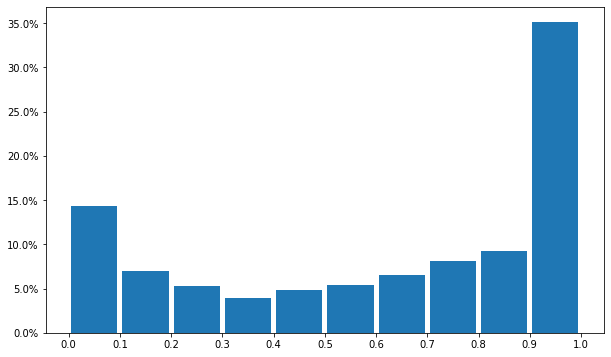

In [234]:
import math
from matplotlib.ticker import PercentFormatter
scores = y_oot_proba.tolist()
classes = []
for x in scores:
    num =( (int)(math.floor( math.fabs( x ) * 10 ) ) ) % 10
    classes.append(num)

groups = np.arange(0, 1.01, step=0.1)

plt.subplots(figsize = (10, 6))
plt.xticks(groups)
plt.hist(x=scores, bins = groups, rwidth=0.9, weights=np.ones(len(scores)) / len(scores))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
# Preparando para o arquivo Pickle

pick = {    "cols_num" : num_features,
            "cat_features" : cat_features,
            "features" : features,
            "target" : target,
            "cv_split" : ShuffleSplit(n_splits=10),
            "grid_parametres" : grid_logi_regre,
            "pipeline_algoritmo" : otimizacao_regression.best_estimator_,
            "roc_auc_score_test" : auc_score_test_logit,
            "roc_auc_score_oot" : auc_score_oot_logit}

historical = pd.Series(pick)
print("Arquivo Pickle Criado")
historical.to_pickle(os.path.join(dir_project, 'Modelling/modelo_otimizado.pkl'))

Arquivo Pickle Criado
